<a href="https://colab.research.google.com/github/neSTORY/Deeplearning_Zero_to_All/blob/master/tips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
tf.compat.v1.enable_eager_execution()

In [2]:
print(tf.__version__)

2.7.0


In [3]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

# Evaluation our model using this test dataset
x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]

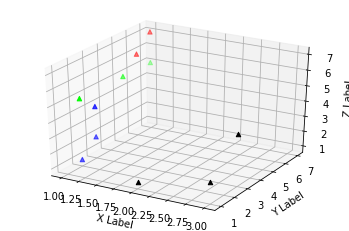

In [4]:
x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]
x3 = [x[2] for x in x_train]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x1, x2, x3, c=y_train, marker="^")

ax.scatter(x_test[0][0], x_test[0][1], x_test[0][2], c="black", marker='^')
ax.scatter(x_test[1][0], x_test[1][1], x_test[1][2], c="black", marker='^')
ax.scatter(x_test[2][0], x_test[2][1], x_test[2][2], c="black", marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [5]:
# dataset 만들기
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

In [20]:
np.array(x_train).shape, np.array(y_train).shape

((8, 3), (8, 3))

In [6]:
# initialize weight and bias
W = tf.Variable(tf.random.normal([3,3]), name ="weight")
b = tf.Variable(tf.random.normal([3]), name = "bias")

In [26]:
# hypothesis 함수 정의
def hypothesis(X):
  hypothesis = tf.nn.softmax(tf.matmul(X,W)+b)
  return hypothesis

# cost 함수 정의
def loss_fn(hypothesis, X, y):
  cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(hypothesis), axis=1))
  return cost

Learning Rate 값을 조정하는 이유
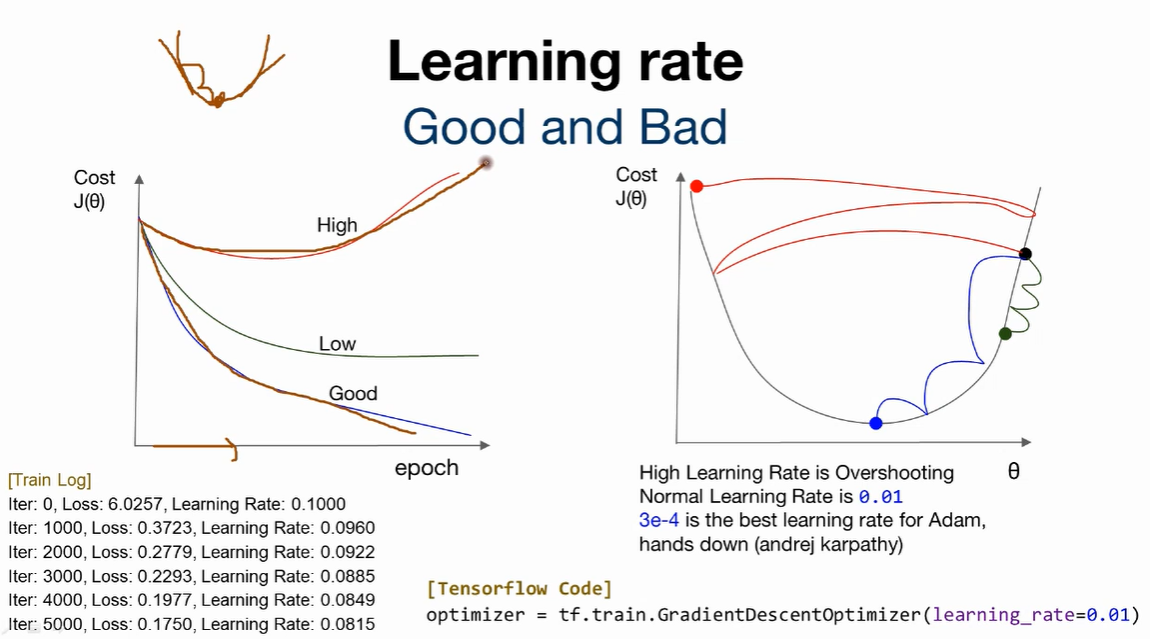

learning rate에 따라 학습을 잘 할수도, 못 할수도 있다.

이에 따라서 학습 중 learning rate를 조절할 필요가 있다.

*cf.자주 쓰는 optimizer인 Adam의 lr은 3e-4가 적당하다고 하다.*

In [8]:
# Learning rate 조절을 해보자

is_decay = True # lr 조절 여부
initial_lr = 0.1

if is_decay:
  lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_lr,
                                                      decay_steps=1000,
                                                      decay_rate = 0.96, # 감소 비율
                                                      staircase = True)
  optimizer = tf.keras.optimizers.SGD(learning_rate= lr)
else:
  optimizer = tf.keras.optimizers.SGD(learning_rate = initial_lr)

def grad(X, y):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(hypothesis(X), X, y)

  return tape.gradient(loss_value, [W, b])

In [9]:
def accuracy_fn(hypothesis, y):
    prediction = tf.argmax(hypothesis, 1)
    is_correct = tf.equal(prediction, tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    return accuracy

In [28]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels  in iter(dataset):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads = grad(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(hypothesis(features),features,labels)))
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)
test_acc = accuracy_fn(hypothesis(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 0.3638
Iter: 100, Loss: 0.3511
Iter: 200, Loss: 0.3396
Iter: 300, Loss: 0.3291
Iter: 400, Loss: 0.3194
Iter: 500, Loss: 0.3105
Iter: 600, Loss: 0.3022
Iter: 700, Loss: 0.2945
Iter: 800, Loss: 0.2873
Iter: 900, Loss: 0.2805
Iter: 1000, Loss: 0.2741
Testset Accuracy: 1.0000


### Overfitting
과적합이라는 뜻으로 train 데이터로 학습을 많이 할 경우 test 데이터가 주어졌을 때 정확도가 떨어지는 현상

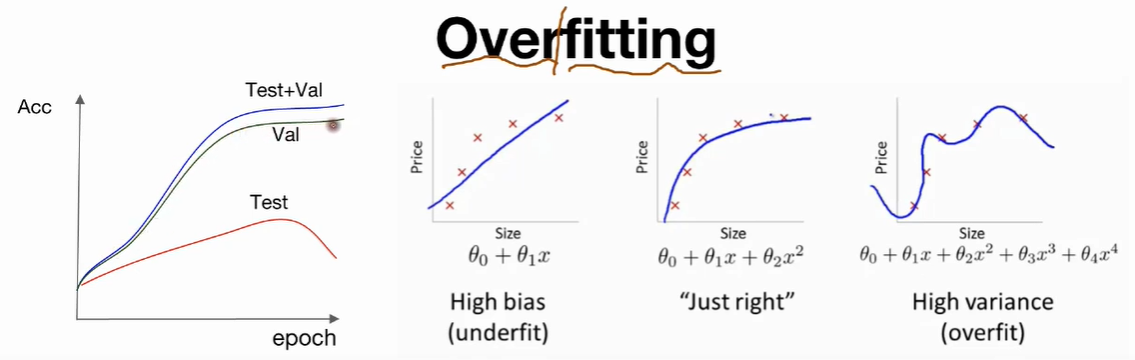

맨 오른쪽 그림과 같이 구불 구불한 모양을 **High variance**(다 변량)이라고 부른다.

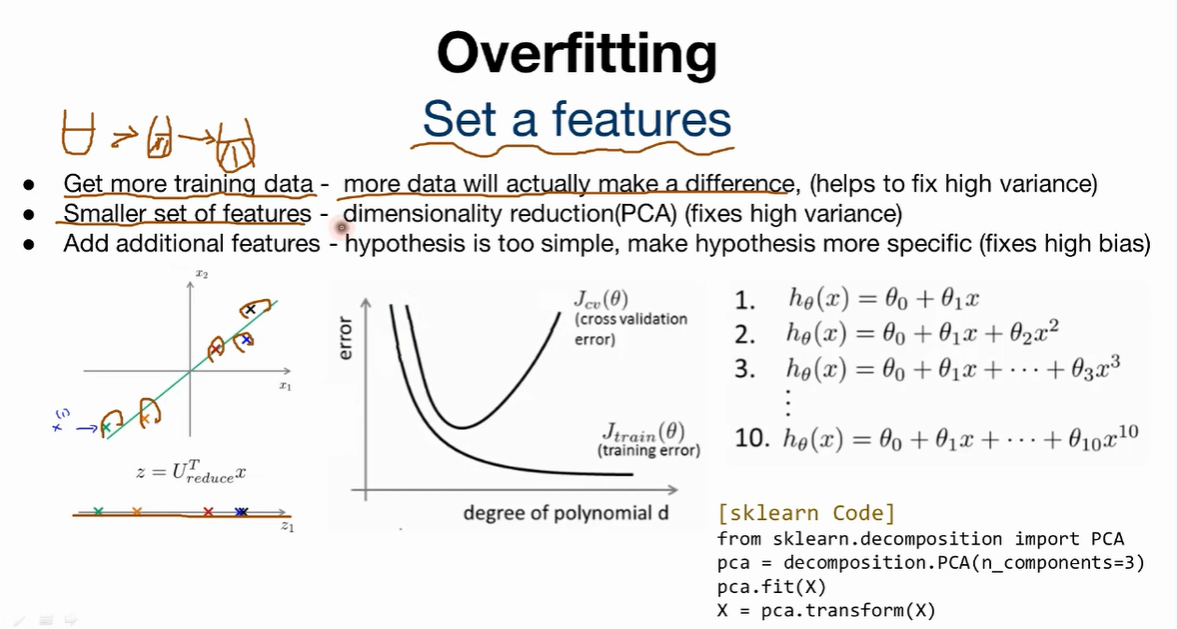

Overfitting을 줄이기 위한 방법
- train 데이터를 증가시키는 방법(Data Augmentation)
- feature의 수를 줄이는 방법(차원축소) => ex)pca
- 부가적인 feature를 추가하는 방법 -> 모델이 너무 단순해서 모델을 좀 더 구체적으로 만들어 준다.
- 정규화 -> 세타(cost에서 weight)값이 특이값(너무 높거나 너무 낮거나)이 있는 경우를 대비해 정규화를 시켜준다.<br> 참고로 여기서 정규화는 normalization이 아니다.
- Dropout(0.5 is common)
- Batch Normalization

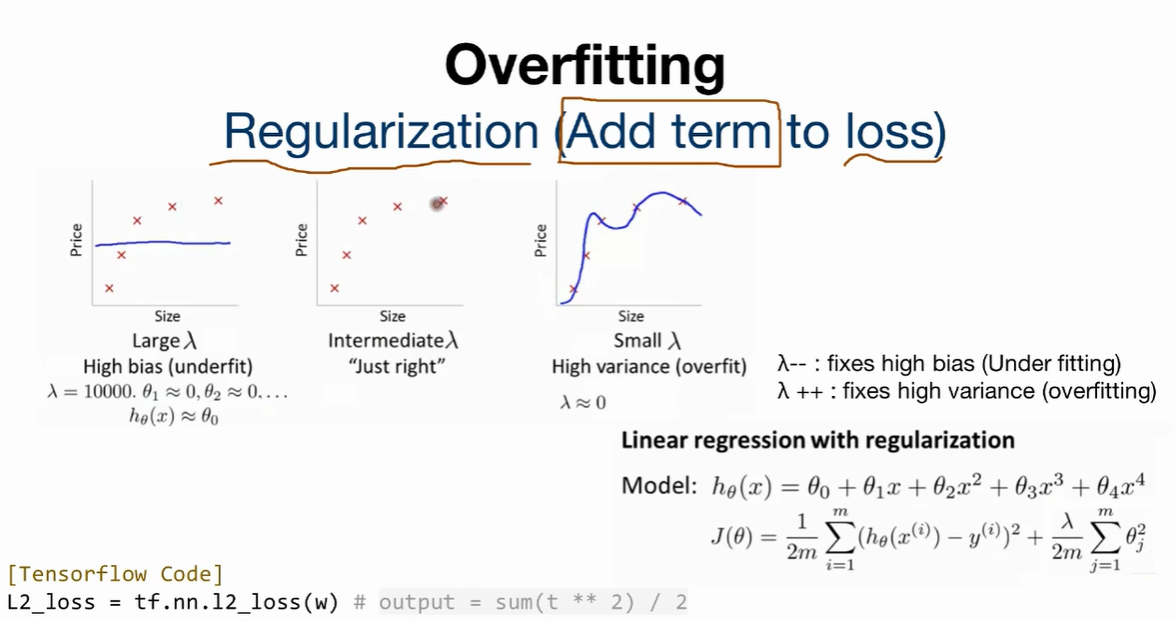

Reguralization을 하는 방법은 기존 cost값을 구하는 식에 term을 주는 것이다. 여기서 term은 loss값을 추가해주는 것으로 대표적으로 L1, L2 loss가 있다.

- L1 loss(Least Absolute Error, LAE): y와 yhat의 차이의 절대값.
- L2 loss(Least Square Error, LSE): y와 yhat의 차이의 제곱.

L1과 L2는 어떤 차이가 있을까?

L2는 제곱을 해주므로 이상치에 대해 민감하다.

loss값을 추가해주는 것의 효과?

weight를 업데이트하다 보면 특정 가중치가 특히 큰 경우 큰 가중치에 의해 과적합이 일어날 수 있다. 그래서 Loss를 더해 이런 특이값을 일반화 시켜줄 수 있다.

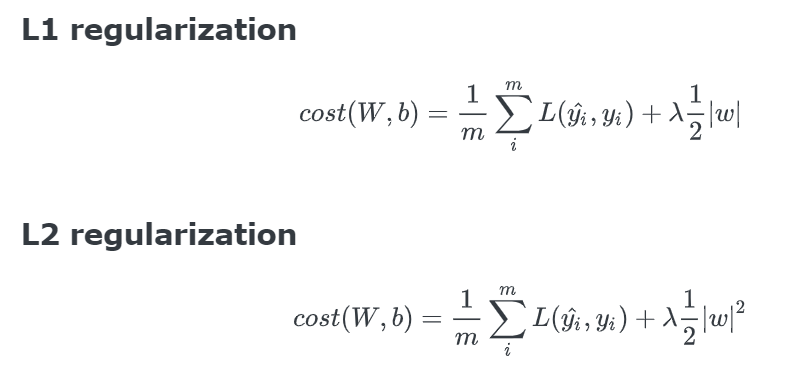

loss 값을 구할 때 추가로 weight값의 절대값 or 제곱을 취하여 더해준다.

## Overfitting code

### None regularization code

In [43]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[ : , :-1]
y_train = xy[ : , -1]

In [44]:
def normalization(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)

  return numerator / denominator

In [45]:
xy = normalization(xy)

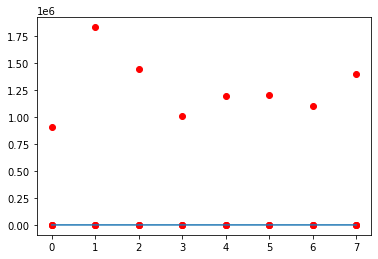

In [46]:
import matplotlib.pyplot as plt

# data 시각화
plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

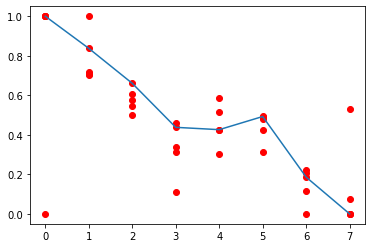

In [47]:
# 정규화한 data 시각화
plt.plot(xy, "ro")
plt.plot(xy[:, -1])

In [54]:
# load dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

# initialize variables
W = tf.Variable(tf.random.normal([4,1]), dtype="float32")
b = tf.Variable(tf.random.normal([1]), dtype="float32")

In [49]:
# hypothesis
def linearReg_fn(X):
  hypothesis = tf.matmul(X, W)+b
  return hypothesis

# loss function
def loss_fn(hypothesis, X, y):
  cost = tf.reduce_mean(tf.square(hypothesis - labels))
  return cost

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)

# gradient
def grad(hypothesis, X, y):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(linearReg_fn(X), X, y)
  return tape.gradient(loss_value, [W,b]), loss_value

In [55]:
EPOCHS = 100

for step in range(EPOCHS+1):
  for features, labels in dataset:
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    hypo_value = linearReg_fn(features)
    grads, loss_value = grad(linearReg_fn(features), features, labels)
    optimizer.apply_gradients(grads_and_vars = zip(grads, [W,b]))
  if step % 10 == 0:
    print("step : {:5}, Loss : {:10.4f}, \nPrediction : {}".format(step, loss_value, hypo_value))

step :     0, Loss : 109342474240.0000, 
Prediction : [[233737.89]
 [470794.88]
 [370305.  ]
 [259508.58]
 [305887.94]
 [308463.94]
 [282699.7 ]
 [359999.75]]
step :    10, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    20, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    30, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    40, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    50, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    60, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    70, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :    80, Loss :        nan, 
Prediction : [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
step :   

### Regularization code + normalization

In [105]:
x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

In [106]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

In [121]:
tf.random.set_seed(2000)
W = tf.Variable(tf.random.normal((4, 1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

In [108]:
# hypothesis
def linearReg_fn(X):
  hypothesis = tf.matmul(X, W)+b
  return hypothesis

In [109]:
X = np.array(x_train, dtype="float32")
y = np.array(y_train, dtype="float32")

In [110]:
def l2_loss(loss, beta=0.01):
  W_reg = tf.nn.l2_loss(W)
  loss = tf.reduce_mean(loss + W_reg * beta)
  return loss

In [111]:
def loss_fn(X, y, flag=False):
  cost = tf.reduce_mean(tf.square(linearReg_fn(X)-y))
  if flag:
    cost = l2_loss(cost)
  return cost

In [112]:
is_decay = True # lr 감소
lr = 0.1

if is_decay:
  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, 50, 0.96, staircase=True)
  optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
else:
  optimizer = tf.keras.optimizers.SGD(learning_rate = lr)

def grad(X, y, l2_flag):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(X,y, l2_flag)
    grads = tape.gradient(loss_value,[W,b])
  return grads, loss_value

In [122]:
EPOCHS = 100

for step in range(EPOCHS + 1):
  for X, y in dataset:
    X = tf.cast(X, tf.float32)
    y = tf.cast(y, tf.float32)

    grads, loss_value = grad(X, y, True)
    optimizer.apply_gradients(grads_and_vars=zip(grads, [W, b]))

    if step%10 == 0:
      print("Iter: {:4}, Loss: {:8.4f}".format(step, loss_value))

Iter:    0, Loss:   0.2107
Iter:   10, Loss:   0.1031
Iter:   20, Loss:   0.0650
Iter:   30, Loss:   0.0455
Iter:   40, Loss:   0.0354
Iter:   50, Loss:   0.0301
Iter:   60, Loss:   0.0271
Iter:   70, Loss:   0.0253
Iter:   80, Loss:   0.0241
Iter:   90, Loss:   0.0233
Iter:  100, Loss:   0.0226


### regularization 비교

In [ ]:
# # l2 regularization False

# Iter: 0, Loss: 0.1882
# Iter: 10, Loss: 0.0850
# Iter: 20, Loss: 0.0493
# Iter: 30, Loss: 0.0311
# Iter: 40, Loss: 0.0217
# Iter: 50, Loss: 0.0169
# Iter: 60, Loss: 0.0143
# Iter: 70, Loss: 0.0130
# Iter: 80, Loss: 0.0122
# Iter: 90, Loss: 0.0118
# Iter: 100, Loss: 0.0115

# # l2 regularization True

# Iter: 0, Loss: 0.2107
# Iter: 10, Loss: 0.1031
# Iter: 20, Loss: 0.0650
# Iter: 30, Loss: 0.0455
# Iter: 40, Loss: 0.0354
# Iter: 50, Loss: 0.0301
# Iter: 60, Loss: 0.0271
# Iter: 70, Loss: 0.0253
# Iter: 80, Loss: 0.0241
# Iter: 90, Loss: 0.0233
# Iter: 100, Loss: 0.0226

### Debug

In [94]:
linearReg_fn(X)

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[-1008707.75],
       [-2029248.  ],
       [-1596618.1 ],
       [-1119616.5 ],
       [-1319292.9 ],
       [-1330384.  ],
       [-1219443.  ],
       [-1552229.2 ]], dtype=float32)>

In [101]:
tf.reduce_mean(tf.square(linearReg_fn(X)-y))

<tf.Tensor: shape=(), dtype=float32, numpy=2045416300000.0>